<a href="https://colab.research.google.com/github/Laxmaan/BMMB/blob/main/Downstream_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q biopython

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import KFold
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Softmax
from tensorflow.keras import layers,losses
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from itertools import accumulate 

In [ ]:
BMMB_ROOT = Path('/content/gdrive/MyDrive/BMMB data')

In [ ]:
%cd '/content/gdrive/MyDrive/BMMB data/BMMB'

/content/gdrive/MyDrive/BMMB data/BMMB


In [ ]:
!ls

datasets	    exec_node2vec_9.sh	scripts
exec_node2vec_6.sh  exec_node2vec.sh	vocab


In [ ]:
#!git pull

In [ ]:
DATA_ROOT = Path('datasets/embs')
algos = ['node2vec','graph2vec']
K = [4,6,9]

labelmap = {4:{'covid':0,'influenza':1},
            6:{'sars':0,'mers':1,'influenza':2},
            9:{'sars':0,'mers':1,'influenza':2}}

def make_ds():
    for algo in algos:
        for k in K:
            ROOT = DATA_ROOT / algo / str(k)
            print(algo,k)
            csvs = [x for x in ROOT.glob("*.csv")]
            vals = []
            labels = []
            metadata=[]
            for csv in csvs:
               
                df = pd.read_csv(csv)

                meta_data = pd.DataFrame()
                meta_data['idx']=df[df.columns[0]]
                meta_data['label']=[  csv.stem  ]*len(df)

                df = df.drop(df.columns[0], axis=1)
                vals.append(df.values)

                labels.extend([  labelmap[k][csv.stem]  ]*len(df))

                metadata.append(meta_data)
            labels = np.array(labels)
            
            vals = np.vstack(vals)
            np.savetxt(ROOT /f"{algo}_{k}_embs.tsv",vals,delimiter='\t')
            metadata = pd.concat(metadata)
            metadata.to_csv(ROOT /f"{algo}_{k}_metadata.tsv",sep='\t',index=None)
            print(labels.shape,vals.shape)
            np.save(ROOT / 'X.npy',vals)
            np.save(ROOT / 'Y.npy',labels)

In [ ]:
make_ds()

node2vec 4


ValueError: ignored

In [ ]:
%cd /content/

In [ ]:
A = np.arange(9).reshape(3,3)
np.savetxt("test.tsv",A,delimiter='\t')

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim,n_classes,dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(dim,)),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(dim, activation='tanh')
    ])
    self.classifier = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(n_classes)                                     
    ])

    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    logits = self.classifier(encoded)
    return decoded,logits


In [ ]:
def custom_loss(X,X_pred, Y_true,Y_pred,c1=2,c2=0.5):
    L1 = losses.SparseCategoricalCrossentropy(from_logits=True)
    L2 = losses.MeanSquaredError()
    loss_value = c1* L1(Y_true,Y_pred) + c2 * tf.cast(L2(X,X_pred),tf.float32)

    return loss_value

In [ ]:
def training_loop(autoencoder,epochs, train_dataset, val_dataset,lr=1e-3,c1=2,c2=0.5,):
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    acc = keras.metrics.SparseCategoricalAccuracy()
    metrics = defaultdict(list)
    for epoch in range(epochs):
        
        acc.reset_states()
        # Iterate over the batches of the dataset.
        train_loss = []
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                decoded,logits = autoencoder(x_batch_train, training=True)  # Logits for this minibatch

                
                acc.update_state(y_batch_train,logits)
                
                # Compute the loss value for this minibatch.
                loss_value = custom_loss(x_batch_train,decoded,y_batch_train,logits,c1,c2)
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, autoencoder.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
            train_loss.append(loss_value)
            # Log every 200 batches.

        train_loss_val = tf.reduce_mean(train_loss)
        print(f" Epoch :{epoch} Train loss :{train_loss_val:.3f}",end=" ")
        print(f"Train accuracy :{acc.result().numpy():.2f}",end=" ")
        metrics['loss'].append(train_loss_val)
        metrics['acc'].append(acc.result().numpy())
        val_losses = []
        acc.reset_states()
        for x_val,y_val in val_dataset:
            decoded,logits = autoencoder(x_val)
            loss_val = custom_loss(x_val,decoded,y_val,logits,c1,c2).numpy()
            val_losses.append(loss_val)

            acc.update_state(y_val,logits)

        val_loss_val = tf.reduce_mean(val_losses)
        print(f"Val loss :{val_loss_val:.3f}",end=" ")
        print(f"Val accuracy :{acc.result().numpy():.2f}")
        metrics['val_loss'].append(val_loss_val)
        metrics['val_acc'].append(acc.result().numpy())

        
    return metrics

In [ ]:
def gen_plots(metrics):
    n_phases = len(metrics)
    phase_size = []
    u,v = 0,None
    for x in metrics:
        psize = len(x['acc'])
        if not v:
            v = u + psize - 0.5
        else:
            v = u + psize
        u = max(0, u)
        phase_size.append((u,v))
        u = v
    print(phase_size)
    data = defaultdict(list)
    if n_phases ==0:
        return
    keys = {x for x in metrics[0]}
    for k in keys:
        for d in metrics:
            data[k] += d[k]

    X = [i for i in range(len(data['acc']))]

    phase_colors = ['blue','purple','cyan']
    phase_names = ['cold start', 'enc+class', 'end-to-end']

    plt.plot(X,data['acc'],label='acc',color = 'black')
    plt.plot(X,data['val_acc'],label='val_acc', color = 'red')
    plt.title('Accuracy vs Epoch')
    
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    for i in range(len(phase_size)):
        u,v = phase_size[i]
        plt.axvspan(u, v, color=phase_colors[i], alpha=0.2,label=phase_names[i])
    plt.legend()
    plt.show()


    plt.plot(X,data['loss'],label='loss',color = 'black')
    plt.plot(X,data['val_loss'],label='val_loss', color = 'red')
    plt.title('Loss vs Epoch')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    for i in range(len(phase_size)):
        u,v = phase_size[i]
        plt.axvspan(u, v, color=phase_colors[i], alpha=0.2,label=phase_names[i])
    plt.legend()
    plt.show()


In [ ]:
def process(algo,k,num_classes,batch_size = 32,latent_dim=3,epochs=[20,20,50]):
    #Load data
    print(f"\n Using {algo} embeddings with k={k}")
    ROOT = DATA_ROOT / algo / str(k)
    X = np.load(ROOT / "X.npy")
    Y = np.load(ROOT / "Y.npy")

    n,dim = X.shape
    print(f"Input data shape :( {X.shape} , {Y.shape} )")
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25)



    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    

    print("Defining Model")
    autoencoder = Autoencoder(latent_dim,num_classes,dim)


    print("Cold Start\n")
    autoencoder.classifier.trainable=False
    m1 = training_loop(autoencoder,epochs[0],train_dataset,val_dataset,lr=1e-5,c1=2,c2=0.5)
    print("\nTraining Encoder and Classifier\n")
    autoencoder.classifier.trainable=True
    autoencoder.decoder.trainable=False
    m2 = training_loop(autoencoder,epochs[1],train_dataset,val_dataset,lr=4e-4,c1=2,c2=0.5)
    print("\nTraining end to end\n")
    autoencoder.decoder.trainable=True
    m3 = training_loop(autoencoder,epochs[2],train_dataset,val_dataset,lr=7e-4,c1=2,c2=0.5)


    decoded,logits = autoencoder(X_test)
    test_acc = keras.metrics.SparseCategoricalAccuracy()(y_test,logits).numpy()

    test_loss = custom_loss(X_test,decoded,y_test,logits).numpy()

    gen_plots([m1,m2,m3])

    return (test_acc,test_loss)


 Using node2vec embeddings with k=4
Input data shape :( (5000, 100) , (5000,) )
Defining Model
Cold Start

 Epoch :0 Train loss :1.391 Train accuracy :0.51 Val loss :1.393 Val accuracy :0.49
 Epoch :1 Train loss :1.391 Train accuracy :0.51 Val loss :1.392 Val accuracy :0.49

Training Encoder and Classifier

 Epoch :0 Train loss :1.387 Train accuracy :0.51 Val loss :1.383 Val accuracy :0.51
 Epoch :1 Train loss :1.376 Train accuracy :0.54 Val loss :1.375 Val accuracy :0.55

Training end to end

 Epoch :0 Train loss :1.364 Train accuracy :0.58 Val loss :1.357 Val accuracy :0.60
 Epoch :1 Train loss :1.347 Train accuracy :0.61 Val loss :1.339 Val accuracy :0.64
[(0, 1.5), (1.5, 3.5), (3.5, 5.5)]


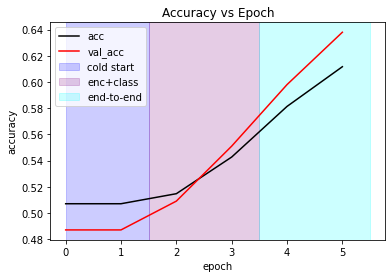

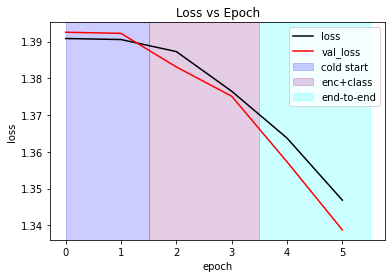

(0.651, 1.3323114)

In [ ]:
process("node2vec",4,2,epochs=[2,2,2])

# Node2vec k = 4


 Using node2vec embeddings with k=4
Input data shape :( (5000, 100) , (5000,) )
Defining Model
Cold Start

 Epoch :0 Train loss :1.394 Train accuracy :0.50 Val loss :1.390 Val accuracy :0.51
 Epoch :1 Train loss :1.394 Train accuracy :0.51 Val loss :1.389 Val accuracy :0.51
 Epoch :2 Train loss :1.393 Train accuracy :0.51 Val loss :1.389 Val accuracy :0.51
 Epoch :3 Train loss :1.389 Train accuracy :0.51 Val loss :1.388 Val accuracy :0.51
 Epoch :4 Train loss :1.394 Train accuracy :0.49 Val loss :1.388 Val accuracy :0.52
 Epoch :5 Train loss :1.391 Train accuracy :0.51 Val loss :1.388 Val accuracy :0.52
 Epoch :6 Train loss :1.391 Train accuracy :0.51 Val loss :1.387 Val accuracy :0.52
 Epoch :7 Train loss :1.393 Train accuracy :0.52 Val loss :1.387 Val accuracy :0.53
 Epoch :8 Train loss :1.389 Train accuracy :0.52 Val loss :1.387 Val accuracy :0.53
 Epoch :9 Train loss :1.390 Train accuracy :0.51 Val loss :1.386 Val accuracy :0.53
 Epoch :10 Train loss :1.388 Train accuracy :0.52 Va

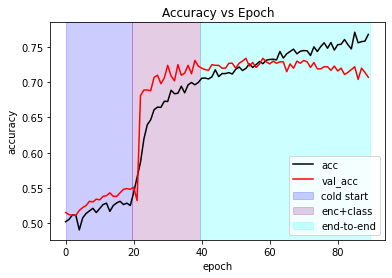

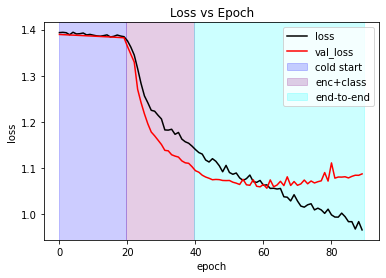


 Using node2vec embeddings with k=6
Input data shape :( (600, 50) , (600,) )
Defining Model
Cold Start

 Epoch :0 Train loss :2.223 Train accuracy :0.35 Val loss :2.207 Val accuracy :0.38
 Epoch :1 Train loss :2.199 Train accuracy :0.36 Val loss :2.206 Val accuracy :0.38
 Epoch :2 Train loss :2.199 Train accuracy :0.37 Val loss :2.206 Val accuracy :0.38
 Epoch :3 Train loss :2.202 Train accuracy :0.39 Val loss :2.205 Val accuracy :0.39
 Epoch :4 Train loss :2.200 Train accuracy :0.38 Val loss :2.205 Val accuracy :0.39
 Epoch :5 Train loss :2.212 Train accuracy :0.37 Val loss :2.204 Val accuracy :0.40
 Epoch :6 Train loss :2.202 Train accuracy :0.38 Val loss :2.204 Val accuracy :0.40
 Epoch :7 Train loss :2.202 Train accuracy :0.34 Val loss :2.203 Val accuracy :0.40
 Epoch :8 Train loss :2.221 Train accuracy :0.36 Val loss :2.202 Val accuracy :0.40
 Epoch :9 Train loss :2.210 Train accuracy :0.38 Val loss :2.202 Val accuracy :0.40
 Epoch :10 Train loss :2.210 Train accuracy :0.39 Val l

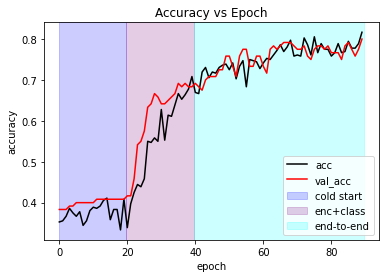

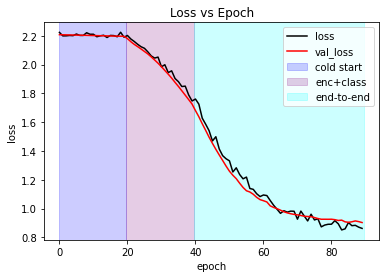


 Using node2vec embeddings with k=9
Input data shape :( (600, 50) , (600,) )
Defining Model
Cold Start

 Epoch :0 Train loss :2.187 Train accuracy :0.33 Val loss :2.196 Val accuracy :0.28
 Epoch :1 Train loss :2.189 Train accuracy :0.32 Val loss :2.196 Val accuracy :0.28
 Epoch :2 Train loss :2.192 Train accuracy :0.31 Val loss :2.196 Val accuracy :0.28
 Epoch :3 Train loss :2.195 Train accuracy :0.32 Val loss :2.195 Val accuracy :0.28
 Epoch :4 Train loss :2.193 Train accuracy :0.32 Val loss :2.195 Val accuracy :0.28
 Epoch :5 Train loss :2.195 Train accuracy :0.31 Val loss :2.195 Val accuracy :0.28
 Epoch :6 Train loss :2.192 Train accuracy :0.30 Val loss :2.195 Val accuracy :0.28
 Epoch :7 Train loss :2.190 Train accuracy :0.31 Val loss :2.195 Val accuracy :0.28
 Epoch :8 Train loss :2.191 Train accuracy :0.31 Val loss :2.194 Val accuracy :0.28
 Epoch :9 Train loss :2.193 Train accuracy :0.32 Val loss :2.194 Val accuracy :0.28
 Epoch :10 Train loss :2.191 Train accuracy :0.32 Val l

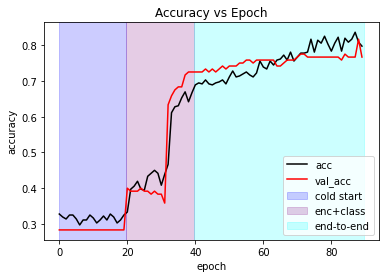

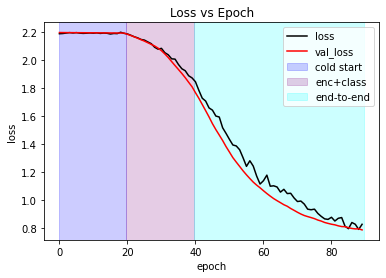


 Using graph2vec embeddings with k=4
Input data shape :( (5000, 100) , (5000,) )
Defining Model
Cold Start

 Epoch :0 Train loss :1.387 Train accuracy :0.52 Val loss :1.395 Val accuracy :0.68
 Epoch :1 Train loss :1.388 Train accuracy :0.51 Val loss :1.394 Val accuracy :0.69
 Epoch :2 Train loss :1.384 Train accuracy :0.51 Val loss :1.394 Val accuracy :0.70
 Epoch :3 Train loss :1.383 Train accuracy :0.51 Val loss :1.393 Val accuracy :0.71
 Epoch :4 Train loss :1.382 Train accuracy :0.52 Val loss :1.392 Val accuracy :0.72
 Epoch :5 Train loss :1.381 Train accuracy :0.52 Val loss :1.391 Val accuracy :0.74
 Epoch :6 Train loss :1.378 Train accuracy :0.50 Val loss :1.390 Val accuracy :0.74
 Epoch :7 Train loss :1.376 Train accuracy :0.52 Val loss :1.388 Val accuracy :0.75
 Epoch :8 Train loss :1.376 Train accuracy :0.52 Val loss :1.385 Val accuracy :0.75
 Epoch :9 Train loss :1.374 Train accuracy :0.51 Val loss :1.382 Val accuracy :0.74
 Epoch :10 Train loss :1.372 Train accuracy :0.50 V

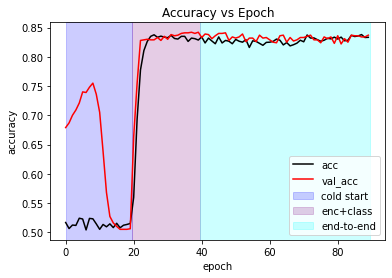

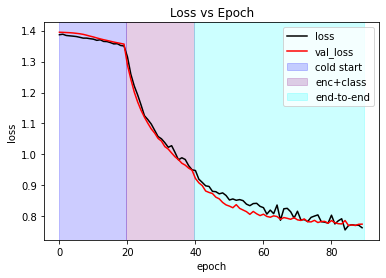


 Using graph2vec embeddings with k=6
Input data shape :( (1000, 50) , (1000,) )
Defining Model
Cold Start

 Epoch :0 Train loss :2.497 Train accuracy :0.29 Val loss :2.454 Val accuracy :0.35
 Epoch :1 Train loss :2.514 Train accuracy :0.30 Val loss :2.447 Val accuracy :0.35
 Epoch :2 Train loss :2.512 Train accuracy :0.30 Val loss :2.439 Val accuracy :0.35
 Epoch :3 Train loss :2.488 Train accuracy :0.30 Val loss :2.432 Val accuracy :0.35
 Epoch :4 Train loss :2.476 Train accuracy :0.31 Val loss :2.426 Val accuracy :0.35
 Epoch :5 Train loss :2.485 Train accuracy :0.31 Val loss :2.418 Val accuracy :0.35
 Epoch :6 Train loss :2.484 Train accuracy :0.28 Val loss :2.411 Val accuracy :0.35
 Epoch :7 Train loss :2.494 Train accuracy :0.31 Val loss :2.404 Val accuracy :0.35
 Epoch :8 Train loss :2.428 Train accuracy :0.29 Val loss :2.397 Val accuracy :0.34
 Epoch :9 Train loss :2.460 Train accuracy :0.29 Val loss :2.391 Val accuracy :0.34
 Epoch :10 Train loss :2.463 Train accuracy :0.31 Va

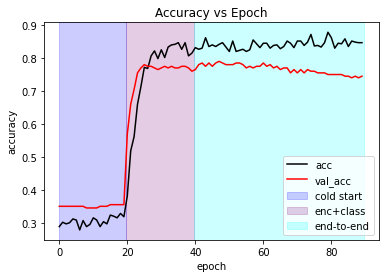

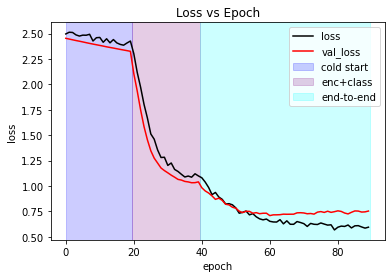


 Using graph2vec embeddings with k=9
Input data shape :( (600, 50) , (600,) )
Defining Model
Cold Start

 Epoch :0 Train loss :2.464 Train accuracy :0.35 Val loss :2.481 Val accuracy :0.25
 Epoch :1 Train loss :2.462 Train accuracy :0.36 Val loss :2.477 Val accuracy :0.25
 Epoch :2 Train loss :2.482 Train accuracy :0.37 Val loss :2.472 Val accuracy :0.25
 Epoch :3 Train loss :2.455 Train accuracy :0.36 Val loss :2.468 Val accuracy :0.25
 Epoch :4 Train loss :2.455 Train accuracy :0.36 Val loss :2.464 Val accuracy :0.25
 Epoch :5 Train loss :2.457 Train accuracy :0.36 Val loss :2.460 Val accuracy :0.25
 Epoch :6 Train loss :2.462 Train accuracy :0.34 Val loss :2.456 Val accuracy :0.25
 Epoch :7 Train loss :2.477 Train accuracy :0.36 Val loss :2.452 Val accuracy :0.25
 Epoch :8 Train loss :2.412 Train accuracy :0.38 Val loss :2.448 Val accuracy :0.25
 Epoch :9 Train loss :2.421 Train accuracy :0.36 Val loss :2.444 Val accuracy :0.25
 Epoch :10 Train loss :2.434 Train accuracy :0.37 Val 

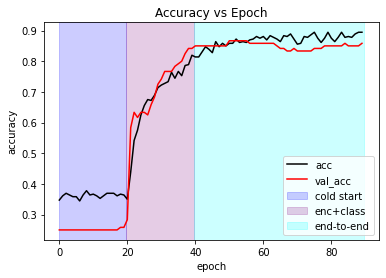

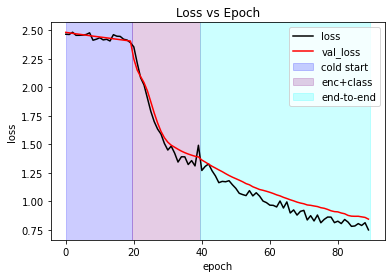

In [ ]:
metrics = {}

for algo in algos:
    for k in K:
        n_classes = 2 if k==4 else 3
        metrics[(algo,k)] = process(algo,k,n_classes)

In [ ]:
metrics

{('graph2vec', 4): (0.831, 0.76151466),
 ('graph2vec', 6): (0.82, 0.610898),
 ('graph2vec', 9): (0.8833333, 0.75977904),
 ('node2vec', 4): (0.704, 1.1046635),
 ('node2vec', 6): (0.73333335, 0.9415503),
 ('node2vec', 9): (0.7916667, 0.84044534)}

In [ ]:
'''
{('graph2vec', 4): (0.853, 0.63696074),
 ('graph2vec', 6): (0.78, 0.7159635),
 ('graph2vec', 9): (0.8666667, 0.64644045),
 ('node2vec', 4): (0.694, 1.1201496),
 ('node2vec', 6): (0.75, 0.85656965),
 ('node2vec', 9): (0.8333333, 1.2024966)}
 '''

In [ ]:
# Instantiate an optimizer.

# Instantiate a loss function.

# Prepare the training dataset.


In [ ]:
X_test[0]

In [ ]:
decoded[0]